In [1]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.1
%env JAX_DEBUG_NANS=true
%env CUDA_VISIBLE_DEVICES=3

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.1
env: JAX_DEBUG_NANS=true
env: CUDA_VISIBLE_DEVICES=3


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import glob
import time
import seaborn as sns

from functools import partial
from cepnem_jax import h5_to_dict, dict_to_h5

from kfold import single_fold
from util import shuffle_data
from config import k_folds, key

sns.set_theme()

# Set the Seaborn style
sns.set_style("dark")

# Customize the Matplotlib parameters
plt.rcParams.update({
    'figure.facecolor': '#212121',   # Background color
    'axes.facecolor': '#212121',     # Axes background color
    'axes.edgecolor': 'white',       # Axes edge color
    'axes.labelcolor': 'white',      # Axes label color
    'xtick.color': 'white',          # X tick color
    'ytick.color': 'white',          # Y tick color
    'text.color': 'white',           # Text color
    'grid.color': 'gray',            # Grid color
    'grid.alpha': 0.5,               # Grid transparency
})

In [3]:
date = time.strftime("%Y-%m-%d")

### Ventral & Head Curve variables with Offset

input_dir_path = f"/home/alex/data3/prj_rim/Decoding_Data/Finalized/DVPostReversal"
save_dir_path = f'/home/alex/data3/prj_rim/Decoding_Data/Finalized/DVPostReversal/Results'

data_source = "end"

pos_cat_key = f"dorsal_turn_{data_source}"
neg_cat_key = f"ventral_turn_{data_source}"
file_paths = glob.glob(f'{input_dir_path}/turn_predict_*.h5')
file_paths.sort()
neuron_classes = [file_path.split("/")[-1][13:-3] for file_path in file_paths]

save_file_name = f"{date}/Turn_Prediction_{data_source}"

### Octanol Encounter Prediction variables

# input_dir_path = "/home/alex/data3_prj_rim/Decoding_Data/OctanolReversal/PerNeuronClass"
# save_dir_path = '/home/alex/data3_prj_rim/Decoding_Data/OctanolReversal/Results'

# pos_cat_key = f"octanol_reversal_neuron_data"
# neg_cat_key = f"normal_reversal_neuron_data"
# file_paths = glob.glob(f'{input_dir_path}/decoding_*.h5')
# file_paths.sort()
# neuron_classes = [file_path.split("/")[-1][9:-3] for file_path in file_paths]

# save_file_name = f"{date}/Octanol_Reversal_Decoding"

# control_indices = [[0,1,2,3], [1,1,2,3]]


In [4]:
neuron_data = {}

for class_idx, neuron_class in enumerate(neuron_classes):
    print(f"Class: {neuron_class} ({class_idx+1}/{len(neuron_classes)})")
    data_dict = h5_to_dict(file_paths[class_idx])

    data = {}
    data["positive"] = jnp.array(data_dict[pos_cat_key])
    data["negative"] =  jnp.array(data_dict[neg_cat_key])

    neuron_data[neuron_class] = data

Class: CEPV (1/13)
Class: IL1V (2/13)
Class: IL2V (3/13)
Class: OLQV (4/13)
Class: RMDV (5/13)
Class: RMEV (6/13)
Class: SAAV (7/13)
Class: SIAV (8/13)
Class: SIBV (9/13)
Class: SMBV (10/13)
Class: SMDV (11/13)
Class: URAV (12/13)
Class: URYV (13/13)


Positive Data Shape: (123, 12, 3), Negative Data Shape: (472, 12, 3)
Train_xs: (2460, 3, 3), Train_ys: (2460, 1)
Truncated len: 2432
Batch Size: 64 n_batches: 38


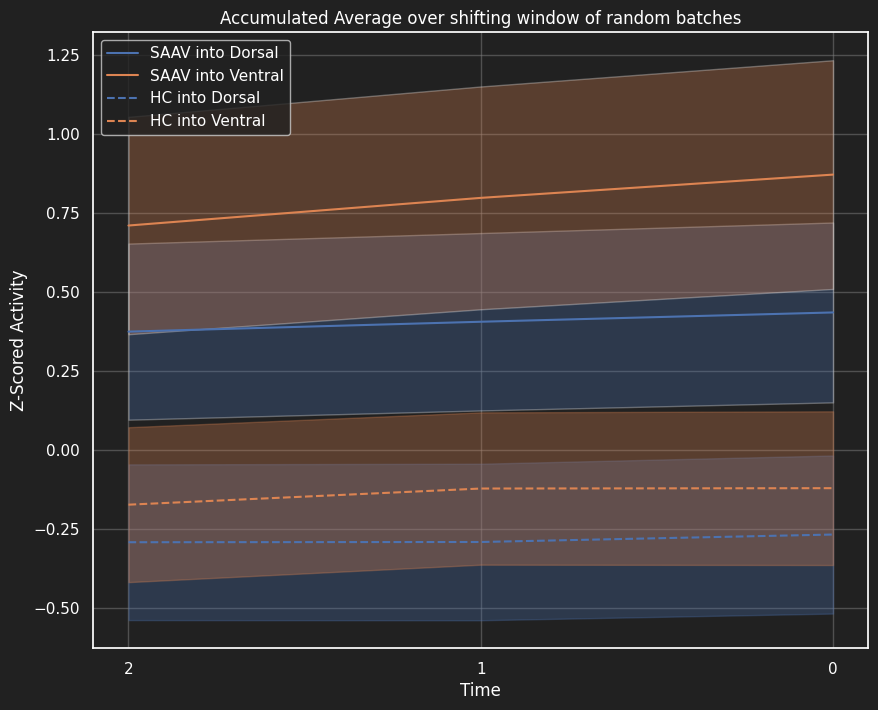

In [5]:
from util import establish_batches

data = neuron_data['SAAV']
    
# Shuffle the positive category data"
key, subkey = jrandom.split(key)
data["positive"], _ = shuffle_data(data["positive"], subkey)

# Shuffle the negative category data
key, subkey = jrandom.split(key)
data["negative"], _ = shuffle_data(data["negative"], subkey)

print(f"Positive Data Shape: {data['positive'].shape}, Negative Data Shape: {data['negative'].shape}")

min_len = min(data["positive"].shape[0], data["negative"].shape[0])
key, subkey = jrandom.split(key)
batched = establish_batches(subkey, data, min_len)

pos_cat = []
neg_cat = []

for x, y in zip(*batched):
    for idx in range(x.shape[0]):
        if y[idx] == 1:
            pos_cat.append(x[idx])
        else:
            neg_cat.append(x[idx])
            
pos_cat = jnp.array(pos_cat)
neg_cat = jnp.array(neg_cat)

neuron = "SAAV"
positive_mean = jnp.mean(pos_cat, axis=(0))
positive_std = jnp.std(pos_cat, axis=(0)) / 4

negative_mean = jnp.mean(neg_cat, axis=(0))
negative_std = jnp.std(neg_cat, axis=(0)) / 4

plt.figure(figsize=(10, 8))

plt.plot(positive_mean[:, 0], label=f"{neuron} into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 0] - positive_std[:, 0], positive_mean[:, 0] + positive_std[:, 0], alpha=0.3)

plt.plot(negative_mean[:, 0], label=f"{neuron} into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 0] - negative_std[:, 0], negative_mean[:, 0] + negative_std[:, 0], alpha=0.3)

plt.plot(positive_mean[:, 1], c='C0', linestyle='--', label="HC into Dorsal")
plt.fill_between(range(len(positive_mean)), positive_mean[:, 1] - positive_std[:, 1], positive_mean[:, 1] + positive_std[:, 1], alpha=0.3, color='C0')

plt.plot(negative_mean[:, 1], c='C1', linestyle='--', label="HC into Ventral")
plt.fill_between(range(len(negative_mean)), negative_mean[:, 1] - negative_std[:, 1], negative_mean[:, 1] + negative_std[:, 1], alpha=0.3, color='C1')

x = jnp.arange(0, len(positive_mean))
plt.xticks(ticks=x, labels=x[::-1])

plt.legend(loc='upper left')
plt.ylabel("Z-Scored Activity")
plt.grid()
plt.xlabel("Time")
plt.title("Accumulated Average over shifting window of random batches")
plt.show()

/home/alex/.conda/envs/CePNEM/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


(-5.0, 5.0)

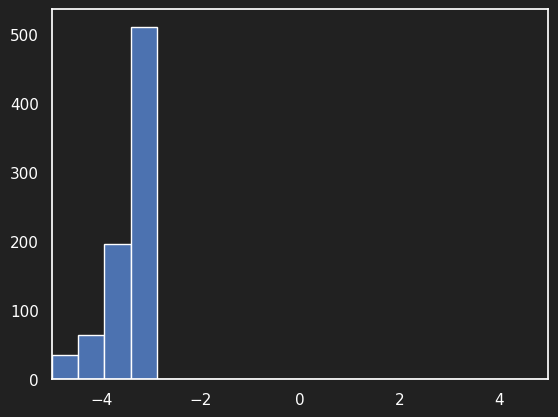

In [88]:
bins = jnp.linspace(-5, 5, 20)
xs = jnp.arange(0, 100, 0.1)
plt.hist(jnp.fft.fft(jnp.sin(xs * (2 * jnp.pi) / 7.0)) * (2 * jnp.pi), bins=bins)
plt.xlim(-5,5)

In [63]:
jnp.fft.fft(data['positive'], axis=1).shape

(123, 12, 3)

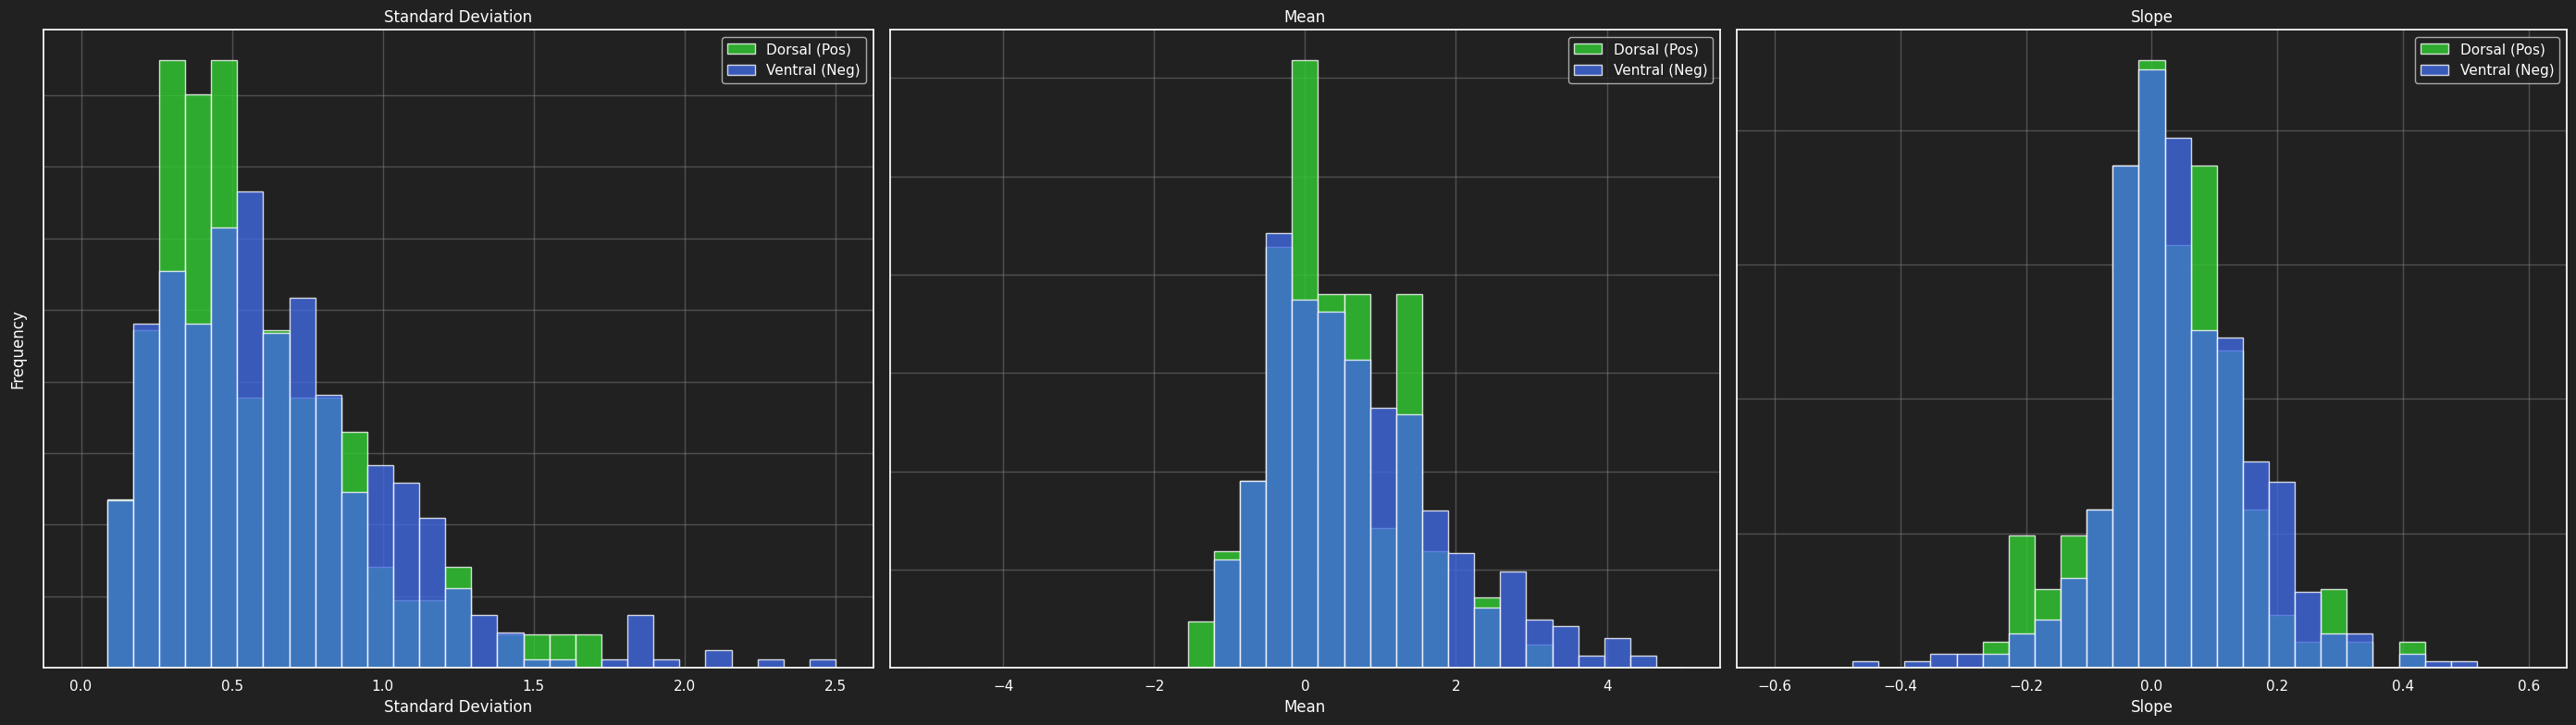

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(28, 8), dpi=100)
n_bins = 30


bins=jnp.linspace(0, 2.5, n_bins)
ax[0].hist(jnp.std(data['positive'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Dorsal (Pos)", color='limegreen')
ax[0].hist(jnp.std(data['negative'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Ventral (Neg)", color='royalblue')
ax[0].legend()
ax[0].set_yticklabels([])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Standard Deviation")
ax[0].grid()
ax[0].set_title("Standard Deviation")


bins=jnp.linspace(-5, 5, n_bins)
ax[1].hist(jnp.mean(data['positive'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Dorsal (Pos)", color='limegreen')
ax[1].hist(jnp.mean(data['negative'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Ventral (Neg)", color='royalblue')
ax[1].legend()
ax[1].set_yticklabels([])
ax[1].set_xlabel("Mean")
ax[1].grid()
ax[1].set_title("Mean")

bins=jnp.linspace(-0.6, 0.6, n_bins)
ax[2].hist((data['positive'][:,-1,:] - data['positive'][:,0,:])[:,0] / data['positive'].shape[1], density=True, alpha=0.8, bins=bins, label="Dorsal (Pos)", color='limegreen')
ax[2].hist((data['negative'][:,-1,:] - data['negative'][:,0,:])[:,0] / data['negative'].shape[1], density=True, alpha=0.8, bins=bins, label="Ventral (Neg)", color='royalblue')
ax[2].legend()
ax[2].set_yticklabels([])
ax[2].set_xlabel("Slope")
ax[2].grid()
ax[2].set_title("Slope")

# bins=jnp.linspace(-5, 5, n_bins)
# ax[3].hist(jnp.fft.fft(data['positive'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Dorsal (Pos)", color='limegreen')
# ax[3].hist(jnp.fft.fft(data['negative'], axis=1)[:,0], density=True, alpha=0.8, bins=bins, label="Ventral (Neg)", color='royalblue')
# ax[3].legend()
# ax[3].set_yticklabels([])
# ax[3].set_xlabel("FFT")
# ax[3].grid()
# ax[3].set_title("FFT")


plt.tight_layout()
plt.show()

In [6]:
# data = neuron_data['SAAV']
    
# # Shuffle the positive category data"
# key, subkey = jrandom.split(key)
# data["positive"], _ = shuffle_data(data["positive"], subkey)

# # Shuffle the negative category data
# key, subkey = jrandom.split(key)
# data["negative"], _ = shuffle_data(data["negative"], subkey)

# print(f"Positive Data Shape: {data['positive'].shape}, Negative Data Shape: {data['negative'].shape}")

# fold = partial(single_fold, data=data)

# results = fold(key, 0, 0)

In [7]:
# fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# channel = 0

# ax[0].plot(results['TestPos'][channel],label="Dorsal (Pos)", c="limegreen")
# ax[0].plot(results['TestNeg'][channel],label="Ventral (Neg)", c="royalblue")
# ax[0].legend()
# ax[0].grid()
# ax[0].set_xlabel("Epoch")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(results['Valid'][channel],label="Valid Acc")
# ax[1].plot(results['Train'][channel],label="Train Acc")
# ax[1].legend()
# ax[1].grid()
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("Accuracy")

# ax[2].plot(results['ValidLoss'][channel],label="Valid Loss")
# ax[2].plot(results['TrainLoss'][channel],label="Train Loss")
# ax[2].legend()
# ax[2].grid()
# ax[2].set_xlabel("Epoch")
# ax[2].set_ylabel("Loss")

# eval_epoch = jnp.argmin(results['ValidLoss'], axis=-1)[channel]
# print(f"Test Pos Accuracy: {results['TestPos'][channel][eval_epoch]:.3f}, Test Neg Accuracy: {results['TestNeg'][channel][eval_epoch]:.3f}")
# print(f"Overall Accuracy: {(results['TestPos'][channel][eval_epoch] + results['TestNeg'][channel][eval_epoch])/2:.3f}")

# plt.suptitle("Single Fold Results")
# plt.show()

In [8]:
neuron_results = {}

In [9]:
def run_neuron(key, class_idx, neuron_class):
    if(neuron_class in neuron_results):
        print(f"Skipping {neuron_class} as it already has results\n")
        return

    print(f"Class: {neuron_class} ({class_idx+1}/{len(neuron_data)})")
    
    data = neuron_data[neuron_class]
    
    # Shuffle the positive category data
    key, subkey = jrandom.split(key)
    data["positive"], _ = shuffle_data(data["positive"], subkey)

    # Shuffle the negative category data
    key, subkey = jrandom.split(key)
    data["negative"], _ = shuffle_data(data["negative"], subkey)

    # min_len = min(data["positive"].shape[0], data["negative"].shape[0])
    # data['positive'] = data['positive'][:min_len]
    # data['negative'] = data['negative'][:min_len]
    
    print(f"Positive Data Shape: {data['positive'].shape}, Negative Data Shape: {data['negative'].shape}")
    
    fold = partial(single_fold, data=data)
    
    key, subkey = jrandom.split(key)
    subkeys = jrandom.split(subkey, k_folds*(k_folds-1))
    results = jax.vmap(lambda i: jax.vmap(lambda j: fold(subkeys[i*(k_folds-1)+j], i, j))(jnp.arange(k_folds-1)))(jnp.arange(k_folds))
    
    total_data_points = min(data["positive"].shape[0], data["negative"].shape[0]) * 2
    
    neuron_results[neuron_class] = {}

    neuron_results[neuron_class]['results'] = results
    neuron_results[neuron_class]['n_total'] = total_data_points

for class_idx, neuron_class in enumerate(neuron_data):
    if(neuron_class != "SAAV"):
        continue
    key, subkey = jrandom.split(key)
    run_neuron(subkey, class_idx, neuron_class)

Class: SAAV (7/13)
Positive Data Shape: (123, 12, 3), Negative Data Shape: (472, 12, 3)
Train_xs: (1460, 3, 2), Train_ys: (1460, 1)
Truncated len: 1408
Batch Size: 64 n_batches: 22
Epoch: 20
Epoch: 40
Epoch: 60
Epoch: 80
Epoch: 100
Epoch: 120
Epoch: 140
Epoch: 160
Epoch: 180
Epoch: 200


Eval Ratio:    1.2151, Data Ratio:    3.8374
Positive Test: 0.5766, Negative Test: 0.4745
Test Eval:     0.5256, Control Eval:  0.4972
Min Val Loss Test:  0.6858, Min Val Loss Control: 0.6917


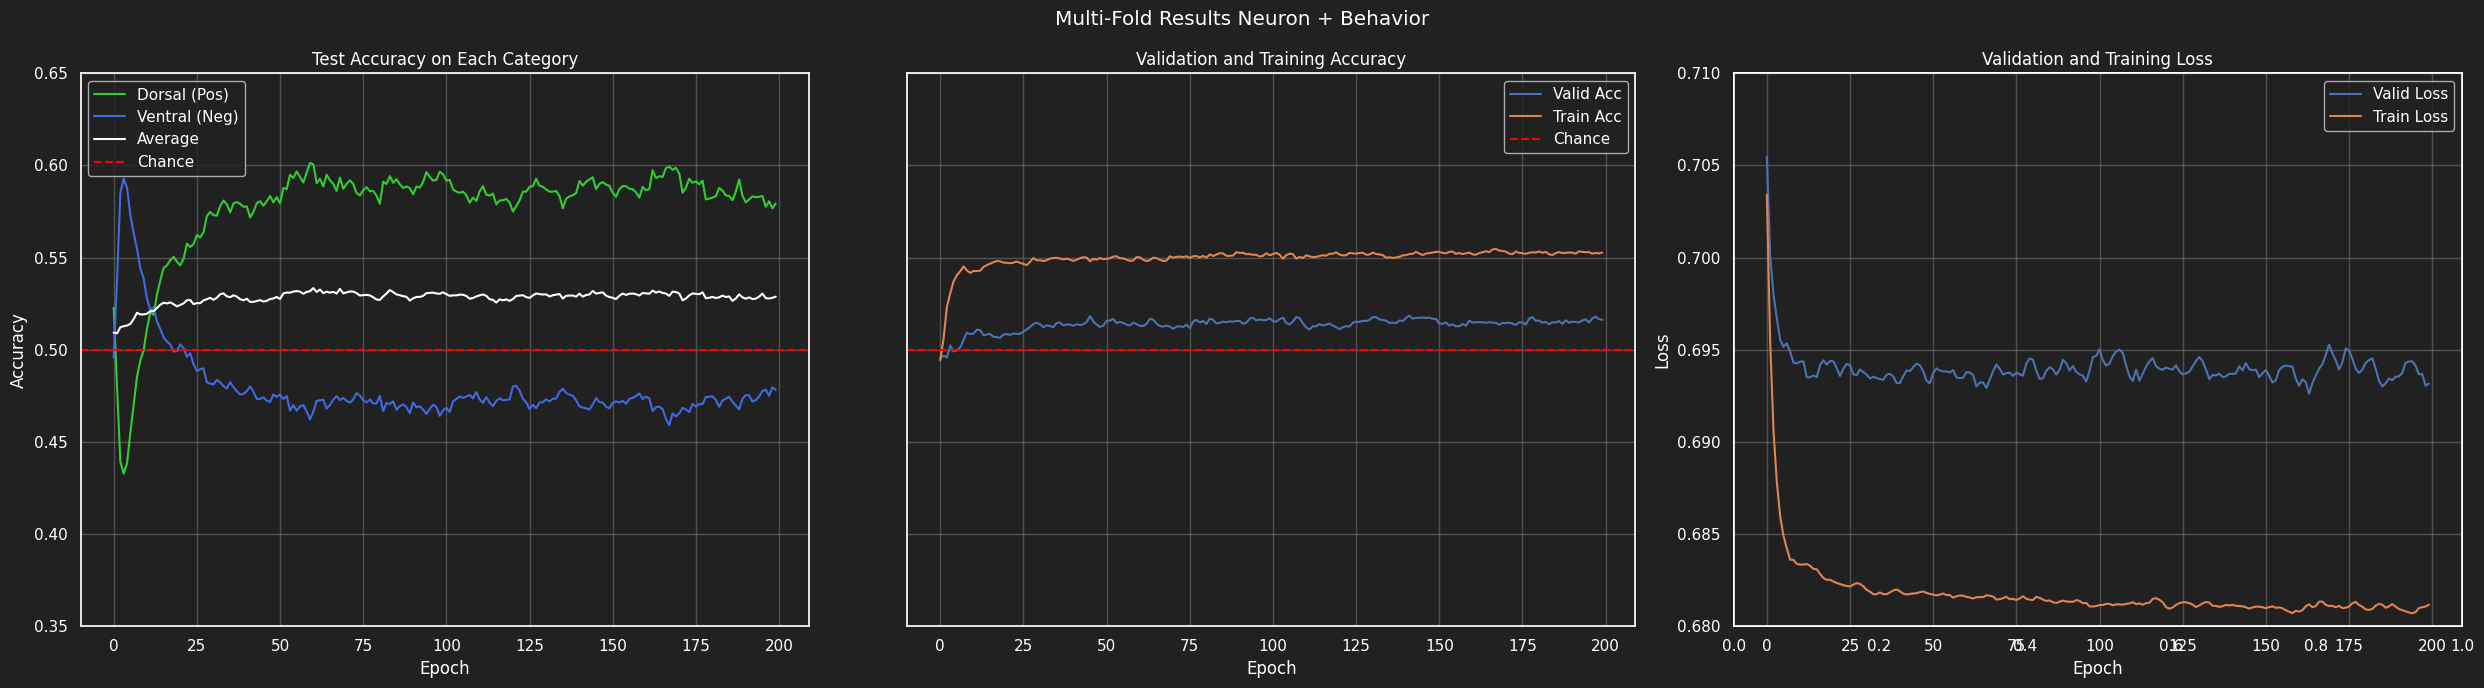

In [10]:
results = neuron_results["SAAV"]['results']

fig, ax = plt.subplots(1, 3, figsize=(25, 7), sharey=True)

channel = 0

ax[0].plot(jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)),label="Dorsal (Pos)", c="limegreen")
ax[0].plot(jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)),label="Ventral (Neg)", c="royalblue")
ax[0].plot((jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)) + jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)))/2, label="Average", c="white")
ax[0].axhline(y=0.5, c="red", linestyle="--", label="Chance")
ax[0].legend(loc='upper left')
ax[0].grid()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0.35, 0.65)
ax[0].set_title("Test Accuracy on Each Category")

ax[1].plot(jnp.mean(results['Valid'][:,:,channel], axis=(0,1)),label="Valid Acc")
ax[1].plot(jnp.mean(results['Train'][:,:,channel], axis=(0,1)),label="Train Acc")
ax[1].axhline(y=0.5, c="red", linestyle="--", label="Chance")
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation and Training Accuracy")

ax[2] = fig.add_subplot(133)
ax[2].plot(jnp.mean(results['ValidLoss'][:,:,channel], axis=(0,1)),label="Valid Loss")
ax[2].plot(jnp.mean(results['TrainLoss'][:,:,channel], axis=(0,1)),label="Train Loss")
ax[2].legend()
ax[2].grid()
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")
ax[2].set_title("Validation and Training Loss")
ax[2].set_ylim(0.68, 0.71)

eval_epoch = jnp.argmin(results['ValidLoss'], axis=-1)
eval_results_pos = jax.vmap(jax.vmap(jax.vmap(lambda epoch, acc: acc[epoch])))(eval_epoch, results['TestPos'])
eval_results_neg = jax.vmap(jax.vmap(jax.vmap(lambda epoch, acc: acc[epoch])))(eval_epoch, results['TestNeg'])

data_ratio = neuron_data['SAAV']['negative'].shape[0] / neuron_data['SAAV']['positive'].shape[0]

pos_test, neg_test = jnp.mean(eval_results_pos, axis=(0,1))[0], jnp.mean(eval_results_neg, axis=(0,1))[0]

eval_ratio = pos_test / neg_test
test_eval = (jnp.mean(eval_results_pos, axis=(0,1))[0] + jnp.mean(eval_results_neg, axis=(0,1))[0])/2
control_eval = (jnp.mean(eval_results_pos, axis=(0,1))[1] + jnp.mean(eval_results_neg, axis=(0,1))[1])/2

min_val_loss = jnp.mean(jnp.min(results['ValidLoss'], axis=-1), axis=(0,1))

print(f"Eval Ratio:    {eval_ratio:.4f}, Data Ratio:    {data_ratio:.4f}")
print(f"Positive Test: {pos_test:.4f}, Negative Test: {neg_test:.4f}")
print(f"Test Eval:     {test_eval:.4f}, Control Eval:  {control_eval:.4f}")
print(f"Min Val Loss Test:  {min_val_loss[0]:.4f}, Min Val Loss Control: {min_val_loss[1]:.4f}")

plt.suptitle(f"Multi-Fold Results {"Neuron + Behavior" if channel==0 else "Behavior Only"}")
plt.tight_layout()
plt.show()

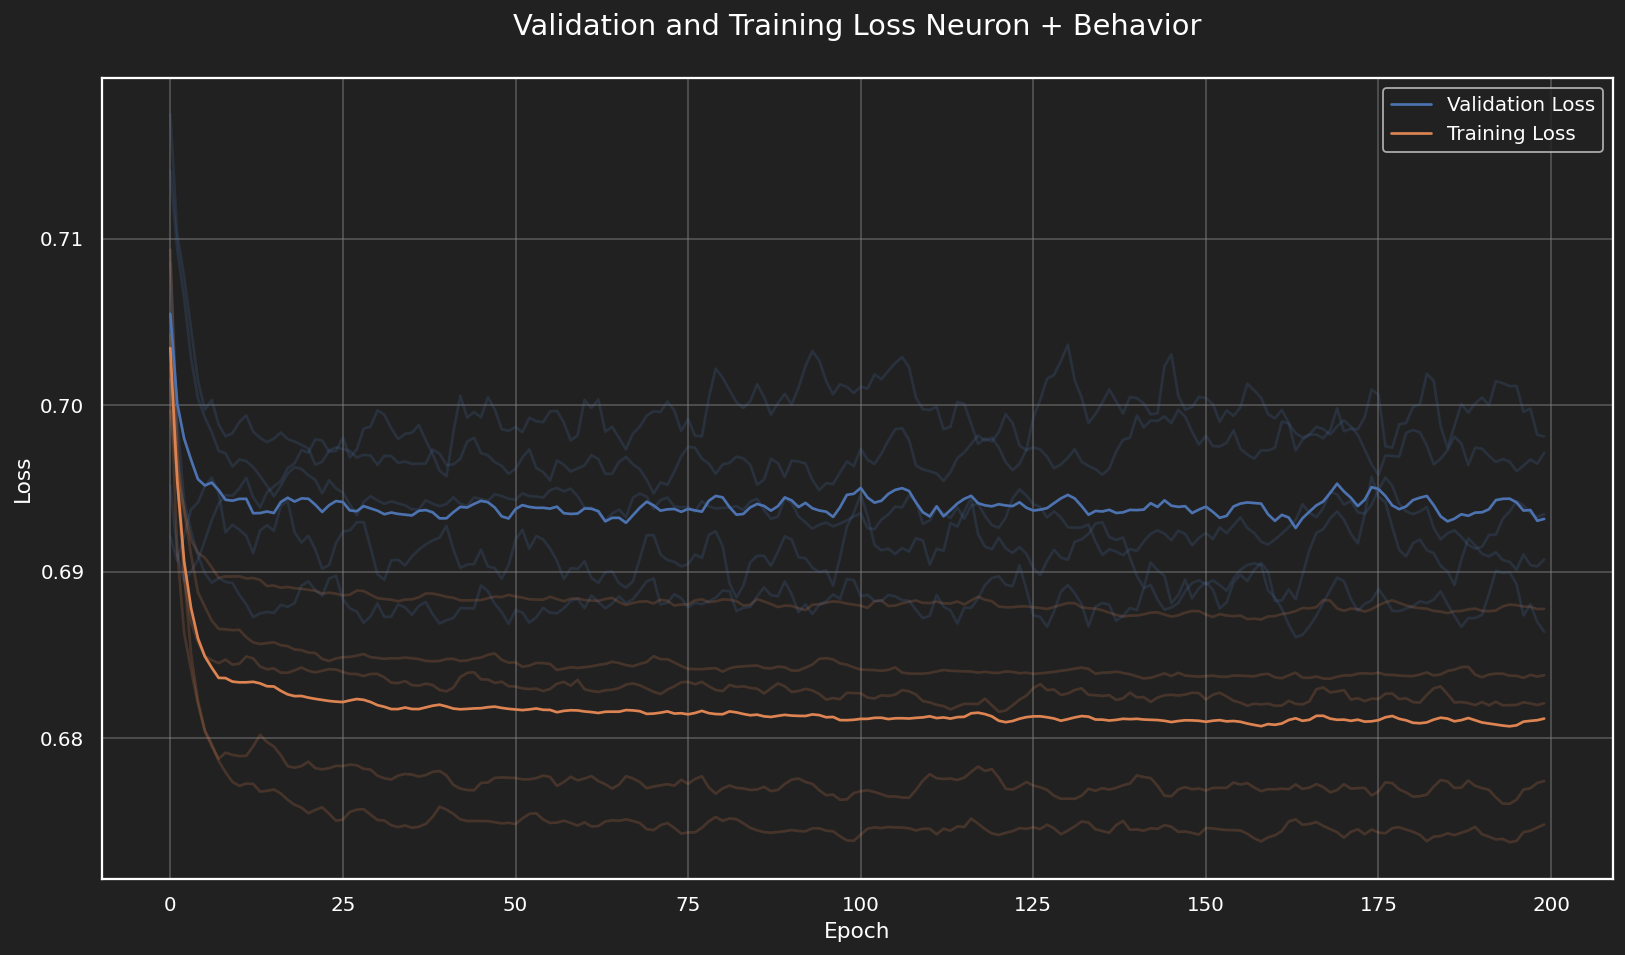

In [13]:
plt.figure(figsize=(15, 8), dpi=130)
ax = plt.subplot()
shaded_alpha = 0.2

for i in range(results['ValidLoss'].shape[0]):
    ax.plot(jnp.mean(results['ValidLoss'][i,:,channel], axis=(0)), c="C0", alpha=shaded_alpha)
    ax.plot(jnp.mean(results['TrainLoss'][i,:,channel], axis=(0)), c="C1", alpha=shaded_alpha)

ax.plot(jnp.mean(results['ValidLoss'][:,:,channel], axis=(0,1)),label="Validation Loss", c="C0")
ax.plot(jnp.mean(results['TrainLoss'][:,:,channel], axis=(0,1)),label="Training Loss", c="C1")
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Validation and Training Loss {"Neuron + Behavior" if channel==0 else "Behavior Only"}\n", fontsize=16)
plt.show()

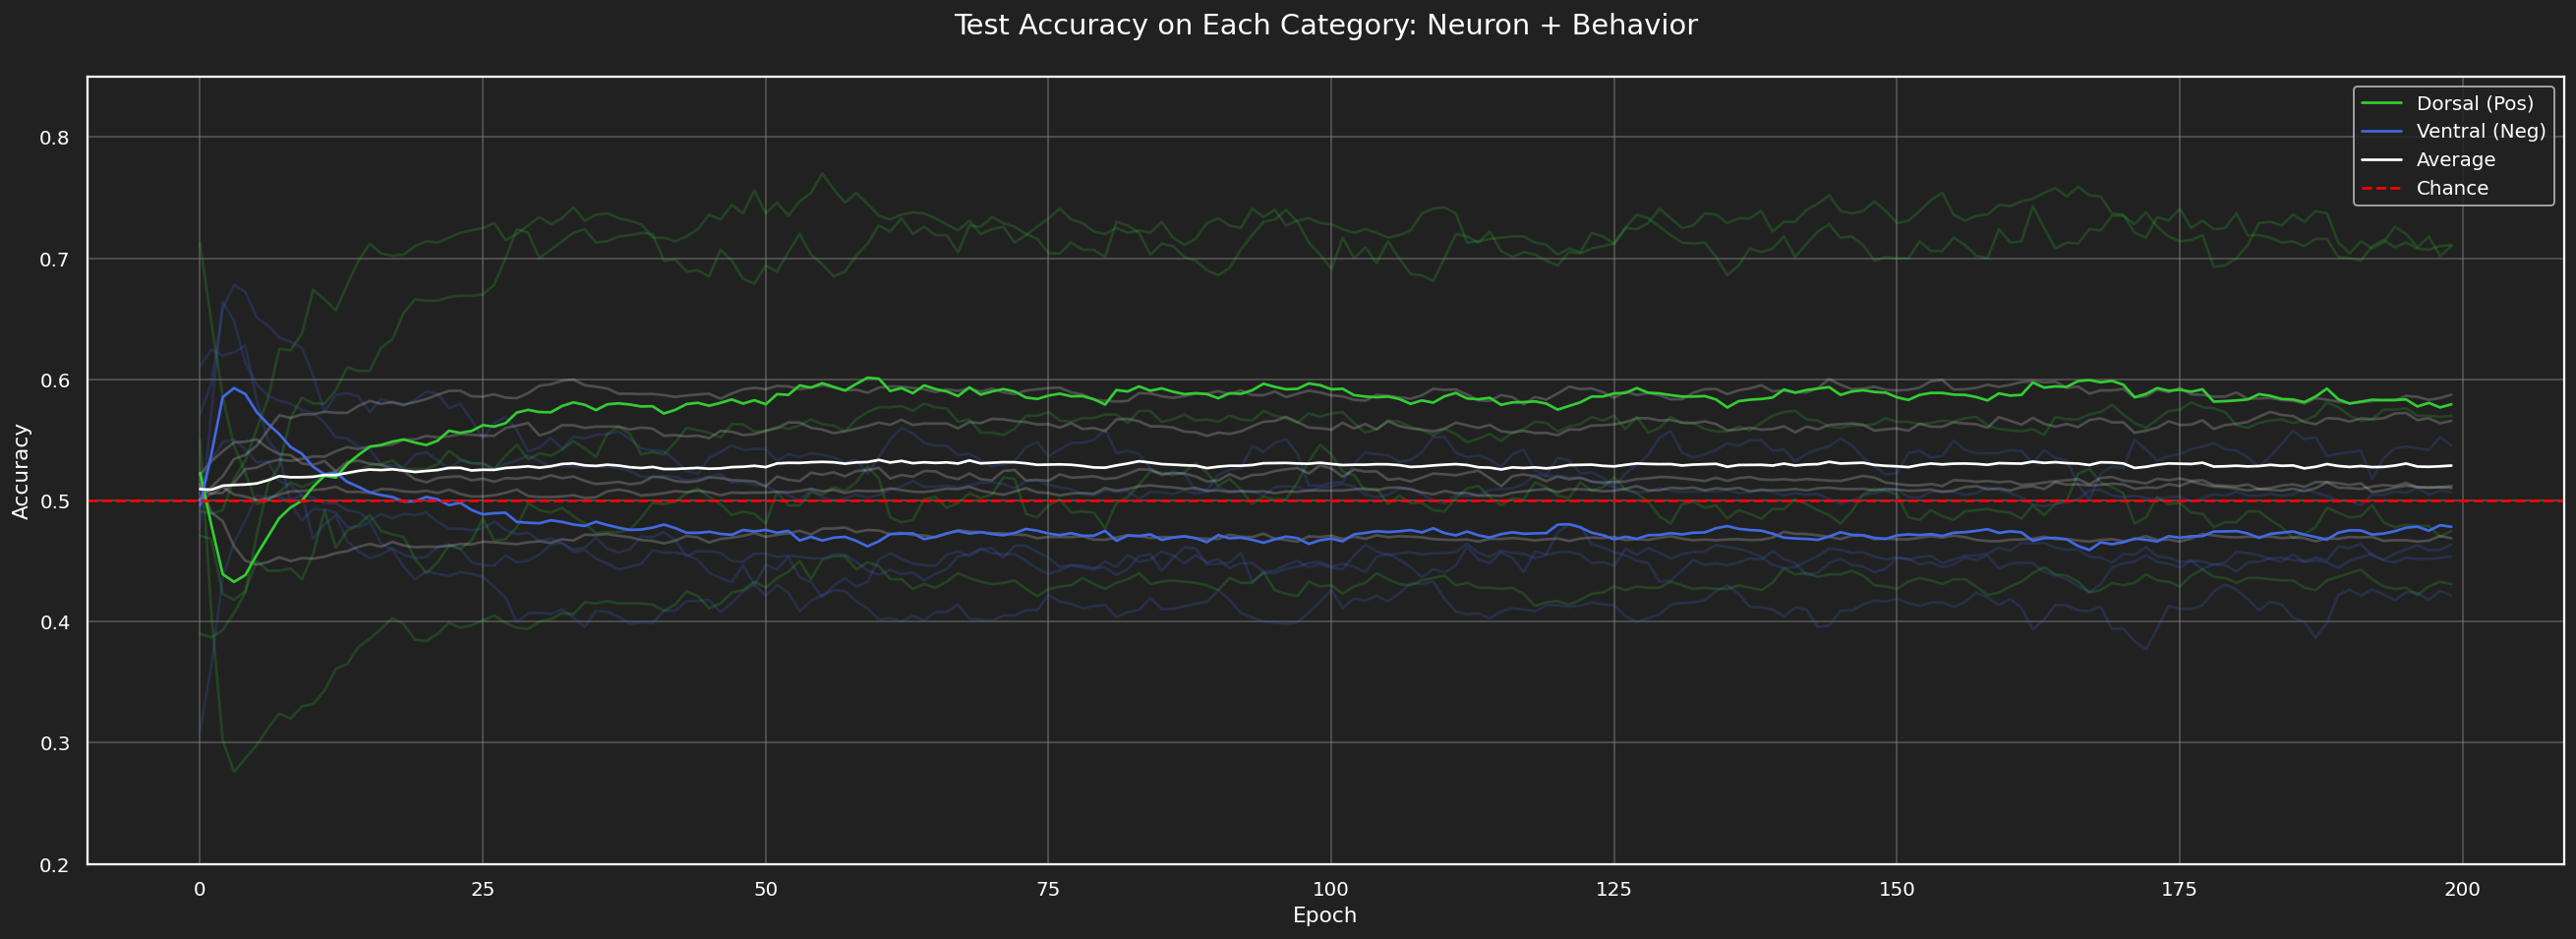

In [14]:
plt.figure(figsize=(25, 8), dpi=130)
ax = plt.subplot()
shaded_alpha = 0.2

for i in range(results['TestPos'].shape[0]):
    ax.plot(jnp.mean(results['TestPos'][i,:,channel], axis=(0)), c="limegreen", alpha=shaded_alpha)
    ax.plot(jnp.mean(results['TestNeg'][i,:,channel], axis=(0)), c="royalblue", alpha=shaded_alpha)
    ax.plot((jnp.mean(results['TestPos'][i,:,channel], axis=(0)) + jnp.mean(results['TestNeg'][i,:,channel], axis=(0)))/2, c="white", alpha=shaded_alpha)

ax.plot(jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)),label="Dorsal (Pos)", c="limegreen")
ax.plot(jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)),label="Ventral (Neg)", c="royalblue")
ax.plot((jnp.mean(results['TestPos'][:,:,channel], axis=(0,1)) + jnp.mean(results['TestNeg'][:,:,channel], axis=(0,1)))/2, label="Average", c="white")
ax.axhline(y=0.5, c="red", linestyle="--", label="Chance")
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.20, 0.85)
ax.set_title(f"Test Accuracy on Each Category: {"Neuron + Behavior" if channel==0 else "Behavior Only"}\n", fontsize=16)
plt.show()

In [21]:
n = neuron_data['SAAV']['positive'].shape[0] + neuron_data['SAAV']['negative'].shape[0]

In [22]:
from scipy.stats import binom

# n = neuron_results['SAAV']['n_total']
# n = 50000
k = int(test_eval * n)
p = 0.5

p_value = 1 - binom.cdf(k, n, p)

print(f"n: {n}, k: {k}, Accuracy: {test_eval:.4f}, p-value: {p_value:.4f}")

n: 595, k: 311, Accuracy: 0.5235, p-value: 0.1255


In [23]:
def index_dist(key, index, n, n_samples=50000):
    def sample(key, _):
        key, subkey = jrandom.split(key)
        subkeys = jrandom.split(subkey, n)
        samples = jax.vmap(lambda sk: jrandom.categorical(sk, jnp.full((n+1,),1.0)))(subkeys)
        sampled_index = jnp.sum(jnp.where(samples > index, 0, 1))

        return key, sampled_index

    _, samples = jax.lax.scan(sample, key, None, length=n_samples)
    return samples

In [33]:
eval_dict = {}
violin_eval_dict = {}

n_eval = int(test_eval * n)
n_control = int(control_eval * n)

print(f"{neuron_class} Test Eval: {test_eval:.4f} ({n_eval}/{n}), Control Eval: {control_eval:.4f} ({n_control}/{n})")

key, subkey = jrandom.split(key)
jax.disable_jit(True)
eval_sampled = index_dist(subkey, n_eval, n)
key, subkey = jrandom.split(key)
control_sampled = index_dist(subkey, n_control, n)

sample_diff = eval_sampled - control_sampled
pval = jnp.sum(jnp.where(sample_diff < 0, 1, 0)) / sample_diff.shape[0]

eval_dict[neuron_class] = {'test_eval': test_eval, 
                            'control_eval': control_eval, 
                            'test_eval_sl': float(jnp.percentile(eval_sampled / n, 2.5)), 
                            'control_eval_sl': float(jnp.percentile(control_sampled / n, 2.5)), 
                            'test_eval_su': float(jnp.percentile(eval_sampled / n, 97.5)), 
                            'control_eval_su': float(jnp.percentile(control_sampled / n, 97.5)), 
                            'p_value': float(pval)}

violin_eval_dict[neuron_class] = {'test_eval_samples': jnp.array(eval_sampled * (100.0 / n), dtype=int), 
                            'control_eval_samples': jnp.array(control_sampled * (100.0 / n), dtype=int), 
                            'p_value': float(pval)}

print(f"p-value: {pval:.4f}\n")

URYV Test Eval: 0.5235 (311/595), Control Eval: 0.4989 (296/595)
p-value: 0.1868



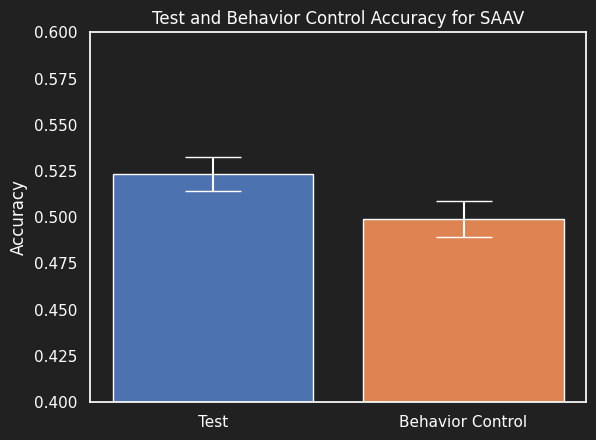

In [50]:
plt.bar(["Test", "Behavior Control"], [test_eval, control_eval], color=['C0', 'C1'])
plt.errorbar(["Test", "Behavior Control"], [test_eval, control_eval], yerr=[test_eval - jnp.percentile(eval_sampled / n, 34), control_eval - jnp.percentile(control_sampled / n, 34)], capsize=20, fmt=',', color='white')
plt.ylabel("Accuracy")
plt.ylim(0.4, 0.6)
plt.title(f"Test and Behavior Control Accuracy for SAAV")
plt.show()

In [ ]:
for i in range(results['ValidLoss'].shape[0]):
    for j in range(results['ValidLoss'].shape[1]):
        plt.plot(results['ValidLoss'][i,j,0], c=f'C{i}', alpha=0.3)
plt.plot(jnp.mean(results['ValidLoss'], axis=(0,1))[0], c="white")

plt.grid()
plt.title(f"Validation Loss of all {k_folds}x{k_folds-1} Inner Models")
plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
from config import hidden_size, learning_rate, batch_size

# dict_to_h5(f'{save_dir_path}/{save_file_name}.h5', neuron_results, overwrite=False)
dict_to_h5(f'{save_dir_path}/{save_file_name}_{hidden_size:02d}_{learning_rate:.0e}_{batch_size:02d}.h5', neuron_results, overwrite=True)